In [ ]:
#IMPORT DEPENDANCIES
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
!git clone https://github.com/JeffMboya/Tensorflow_Cup_Detection.git #LOAD THE DATA

Cloning into 'Tensorflow_Cup_Detection'...
remote: Enumerating objects: 482, done.
remote: Counting objects: 100% (482/482), done.
remote: Compressing objects: 100% (358/358), done.
remote: Total 482 (delta 131), reused 458 (delta 124), pack-reused 0
Receiving objects: 100% (482/482), 2.69 MiB | 8.10 MiB/s, done.
Resolving deltas: 100% (131/131), done.


In [ ]:
image_size = (299, 299) #Size to resize images to after they are read from the disk. 
#Defaults to (256, 256). Since the pipeline processes batches of images that must all have the same size, this must be provided.
batch_size = 32
 
#split the data into training and validation set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(    #Generates a tf.data.Dataset from image files in the directory.
    "/content/Tensorflow_Cup_Detection/Data",
    validation_split=0.2,
    subset="training",
    seed=1337, #Optional random seed for shuffling and transformations.
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/Tensorflow_Cup_Detection/Data",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 174 files belonging to 2 classes.
Using 140 files for training.
Found 174 files belonging to 2 classes.
Using 34 files for validation.


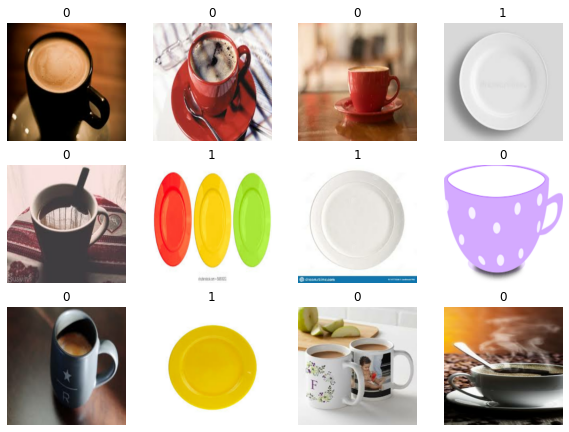

In [ ]:
#visualise the data
import matplotlib.pyplot as plt
 
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
#since our training dataset is small, apply random data augmentation
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.experimental.preprocessing.RandomContrast(factor=0.1),
        layers.experimental.preprocessing.RandomZoom(.2, .2)
        
    ]
)

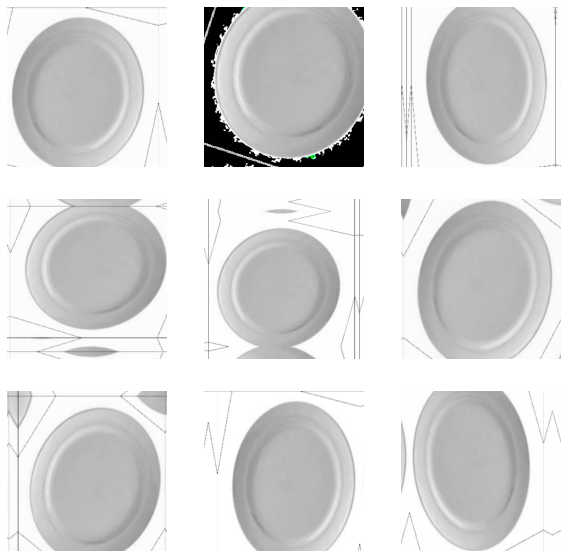

In [ ]:
#Let's visualize what the augmented samples look like, by applying data_augmentation repeatedly to the first image in the dataset:
 
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [ ]:
#build the model

image_size=299
 
base_model = keras.applications.InceptionResNetV2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(image_size, image_size, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.
 
# Freeze the base_model
base_model.trainable = False
 
# Create new model on top
inputs = keras.Input(shape=(image_size,image_size, 3))
x = data_augmentation(inputs)  # Apply random data augmentation
 
# Pre-trained Xception weights requires that input be normalized
# from (0, 255) to a range (-1., +1.), the normalization layer
# does the following, outputs = (inputs - mean) / sqrt(var)
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
# Scale inputs to [-1, +1]
x = norm_layer(x)
norm_layer.set_weights([mean, var])
 
# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
   
 
activation = "sigmoid"
units = 1
 
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(units, activation=activation)(x)
model = keras.Model(inputs, outputs)
 
model.summary()

219062272/219055592 [==============================] - 2s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 299, 299, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 299, 299, 3)       7         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 8, 8, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_____________________________________________________

In [ ]:
#define callbacks

callback=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.01,
    patience=3
)
 
 
#train the top layer
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)
 
epochs = 20
model.fit(train_ds, epochs=epochs, callbacks=callback, validation_data=val_ds)

Epoch 1/20
5/5 [==============================] - 72s 14s/step - loss: 0.7091 - binary_accuracy: 0.5071 - val_loss: 0.6705 - val_binary_accuracy: 0.4412
Epoch 2/20
5/5 [==============================] - 68s 14s/step - loss: 0.6776 - binary_accuracy: 0.5143 - val_loss: 0.6482 - val_binary_accuracy: 0.4412
Epoch 3/20
5/5 [==============================] - 69s 14s/step - loss: 0.6517 - binary_accuracy: 0.5429 - val_loss: 0.6106 - val_binary_accuracy: 0.6765
Epoch 4/20
5/5 [==============================] - 69s 14s/step - loss: 0.6177 - binary_accuracy: 0.8357 - val_loss: 0.5818 - val_binary_accuracy: 0.9412
Epoch 5/20
5/5 [==============================] - 70s 14s/step - loss: 0.5991 - binary_accuracy: 0.9357 - val_loss: 0.5645 - val_binary_accuracy: 0.9706
Epoch 6/20
5/5 [==============================] - 74s 15s/step - loss: 0.5757 - binary_accuracy: 0.9643 - val_loss: 0.5524 - val_binary_accuracy: 0.9706
Epoch 7/20
5/5 [==============================] - 69s 14s/step - loss: 0.5622 - bi

In [ ]:
# Fine-tune the entire model by unfreezing the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()
 
callback=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.01,
    patience=3
)
 
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)
 
epochs = 10
model.fit(train_ds, epochs=epochs, callbacks=callback, validation_data=val_ds)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 299, 299, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 299, 299, 3)       7         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 8, 8, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                

In [ ]:
 #run prediction on images in the test dataset
 
 img = keras.preprocessing.image.load_img (
"/content/Tensorflow_Cup_Detection/test_images/cup (86).jpg", target_size=(image_size,image_size))
 
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis
 
predictions = model.predict(img_array)
score = predictions[0]
 
 
print(
    "This image is %.2f percent cup and %.2f percent plate."
    % (100 * (1-score), 100 *(score))
)

This image is 99.84 percent cup and 0.16 percent plate.
